In [1]:
!pip install --upgrade pip
!pip install -qU tfx

In [2]:
import os
 
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import example_gen_pb2
from tfx.components import ImportExampleGen
from tfx.components import StatisticsGen
from tfx.components import SchemaGen
from tfx.components import ExampleValidator
from tfx.components import Transform

# This is the data

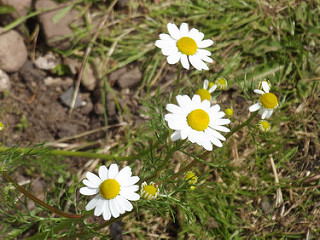

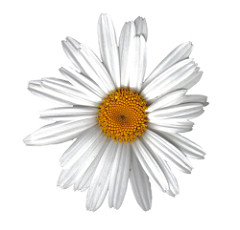

In [3]:
import tensorflow as tf
import IPython.display as display
 
raw_image_dataset = tf.data.TFRecordDataset('./data/tfrecords_small.tfrecord-00000-of-00001')
 
# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}
 
def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)
 
parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
 
for image_features in list(parsed_image_dataset)[:2]:
  image_raw = image_features['image_raw'].numpy()
  display.display(display.Image(data=image_raw))

# Start the interactive TFX pipeline

In [4]:
context = InteractiveContext(pipeline_root='./flowers_tfx/')

In [5]:
output = example_gen_pb2.Output(
             split_config=example_gen_pb2.SplitConfig(splits=[
                 example_gen_pb2.SplitConfig.Split(name='train', hash_buckets=6),
                 example_gen_pb2.SplitConfig.Split(name='test', hash_buckets=4)
             ]))

In [6]:
example_gen = ImportExampleGen(input_base='./data',
                               output_config=output)
 
context.run(example_gen
           )

ExecutionResult(
    component_id: ImportExampleGen
    execution_id: 6
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 8
        type_id: 5
        uri: "./flowers_tfx/ImportExampleGen/examples/6"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"test\"]"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:1,total_bytes:1100898,xor_checksum:1613388642,sum_checksum:1613388642"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            string_value: "0"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [7]:
statistics_gen = StatisticsGen(examples = example_gen.outputs['examples'])
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 7
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(artifact: id: 9
        type_id: 7
        uri: "./flowers_tfx/StatisticsGen/statistics/7"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"test\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "statistics"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "StatisticsGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 7
        name: "ExampleStatistics"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [8]:
context.show(statistics_gen.outputs['statistics'])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [9]:
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=True)
context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 8
    outputs:
        schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 10
        type_id: 9
        uri: "./flowers_tfx/SchemaGen/schema/8"
        custom_properties {
          key: "name"
          value {
            string_value: "schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "SchemaGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 9
        name: "Schema"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [10]:
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'depth',INT,required,,-
'height',INT,required,,-
'image_raw',BYTES,required,,-
'label',INT,required,,-
'width',INT,required,,-


In [11]:
example_validator = ExampleValidator(
      statistics=statistics_gen.outputs['statistics'],
      schema=schema_gen.outputs['schema']
      )
context.run(example_validator)
context.show(example_validator.outputs['anomalies'])

In [12]:
%%writefile transform.py
 
import tensorflow as tf
import tensorflow_transform as tft
 
def transform_key(key):
    return key + '_xf'
 
def process_image(raw_image):
    raw_image = tf.reshape(raw_image, [])
    img_rgb = tf.image.decode_jpeg(raw_image, channels=3)
    img = tf.image.convert_image_dtype(img_rgb, tf.float32)
    resized_img = tf.image.resize_with_pad(
        img,
        target_height=300,
        target_width=300,
    )
    img_grayscale = tf.image.rgb_to_grayscale(resized_img)
    return tf.reshape(img_grayscale, [300*300*1])

    # return tf.reshape(resized_img, [300*300*3])
 
 
def preprocessing_fn(inputs):
    image_raw = inputs['image_raw']
    label = inputs['label']
    
    img_preprocessed=tf.map_fn(process_image, image_raw, dtype=tf.float32)
    # working with a lambda function should give the same result
    # fn = lambda image: process_image(image)
    # img_preprocessed=tf.map_fn(fn, image_raw, dtype=tf.float32)
    
    return {
      'img_preprocessed_xf': img_preprocessed,
      'label_xf': label,
    }

Overwriting transform.py


In [13]:
# create the Transform Component
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath("transform.py")
)
context.run(transform)

Instructions for updating:
Schema is a deprecated, use schema_utils.schema_from_feature_spec to create a `Schema`


Instructions for updating:
Schema is a deprecated, use schema_utils.schema_from_feature_spec to create a `Schema`


Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: ./flowers_tfx/Transform/transform_graph/10/.temp_path/tftransform_tmp/6a0810967ebb426eab253f5bd9d9fbb6/saved_model.pb


INFO:tensorflow:SavedModel written to: ./flowers_tfx/Transform/transform_graph/10/.temp_path/tftransform_tmp/6a0810967ebb426eab253f5bd9d9fbb6/saved_model.pb


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


ExecutionResult(
    component_id: Transform
    execution_id: 10
    outputs:
        transform_graph: Channel(
            type_name: TransformGraph
            artifacts: [Artifact(artifact: id: 12
        type_id: 13
        uri: "./flowers_tfx/Transform/transform_graph/10"
        custom_properties {
          key: "name"
          value {
            string_value: "transform_graph"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 13
        name: "TransformGraph"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        transformed_examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 13
        type_id: 5
        uri: "./flowers_tfx/Transform/transformed_examples/10"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"test\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "transformed_examples"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        updated_analyzer_cache: Channel(
            type_name: TransformCache
            artifacts: [Artifact(artifact: id: 14
        type_id: 14
        uri: "./flowers_tfx/Transform/updated_analyzer_cache/10"
        custom_properties {
          key: "name"
          value {
            string_value: "updated_analyzer_cache"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 14
        name: "TransformCache"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [14]:
import glob

f=glob.glob(transform.outputs['transformed_examples'].get()[0].uri+'/train/*')[0]

In [15]:
tfdata = tf.data.TFRecordDataset(f, compression_type='GZIP')

In [16]:
import pprint
import numpy as np

pp = pprint.PrettyPrinter()

for tfrecord in tfdata.take(1):
    serialized_example = tfrecord.numpy()
    example = tf.train.Example()
    example.ParseFromString(serialized_example)
    pp.pprint(example)

features {
  feature {
    key: "img_preprocessed_xf"
    value {
      float_list {
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
   

In [17]:
!pip install matplotlib

90000


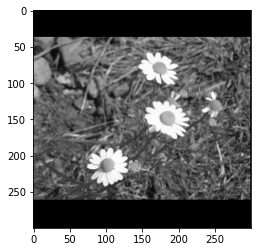

In [18]:
import matplotlib.pyplot as plt

for tfrecord in tfdata.take(1):
    serialized_example = tfrecord.numpy()
    example = tf.train.Example()
    example.ParseFromString(serialized_example)
    
    data = example.features.feature['img_preprocessed_xf'].float_list.value
    print(len(data))

    plt.imshow(np.reshape(np.array(data)*255, [300,300]).astype(np.uint8),cmap='gray', vmin=0, vmax=255)